In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-stocks-data-2025/walmart_stock_prices.csv


**In this notebook, I analyze Walmart's stock price trends using time series techniques. I start with data preprocessing, exploratory analysis, and volatility assessment. Then, I build ARIMA, LSTM, and Linear Regression models to forecast stock prices. I evaluate and compare each model’s performance using visualizations and key metrics. Finally, I derive insights on stock trends, volatility, and the best predictive approach. 🚀📊**

# **📌 Step 1: Import Required Libraries**

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Analysis
import statsmodels.api as sm

# Warnings
import warnings
warnings.filterwarnings("ignore")

# **📌 Step 2: Load the Walmart Stock Price Dataset**

In [3]:
file_path = "/kaggle/input/walmart-stocks-data-2025/walmart_stock_prices.csv"
df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1972-08-25 00:00:00-04:00,0.011463,0.011683,0.011463,0.011639,7526400,0.0,0.0
1,1972-08-28 00:00:00-04:00,0.011639,0.011727,0.011595,0.011595,2918400,0.0,0.0
2,1972-08-29 00:00:00-04:00,0.011551,0.011551,0.011463,0.011463,5836800,0.0,0.0
3,1972-08-30 00:00:00-04:00,0.011463,0.011463,0.011374,0.011463,1228800,0.0,0.0
4,1972-08-31 00:00:00-04:00,0.011374,0.011374,0.011286,0.011286,2611200,0.0,0.0


**✅ Observations:**
> **The dataset includes Date, Open, High, Low, Close, Volume, Dividends, and Stock Splits.**

> **I need to process the Date column to ensure correct datetime formatting.**

# **📌 Step 3: Data Preprocessing & Cleaning**

In [4]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13233 entries, 1972-08-25 00:00:00-04:00 to 2025-02-21 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          13233 non-null  float64
 1   High          13233 non-null  float64
 2   Low           13233 non-null  float64
 3   Close         13233 non-null  float64
 4   Volume        13233 non-null  int64  
 5   Dividends     13233 non-null  float64
 6   Stock Splits  13233 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 827.1+ KB


**✅ Why?**

> **Time series analysis requires a datetime index.**

> **This allows me to analyze trends, seasonality, and volatility properly.**

In [5]:
df.isnull().sum()
# Fill missing values using forward fill method
df.fillna(method="ffill", inplace=True)

**✅ Why?**

> **Stocks don’t trade on weekends or holidays, leading to missing values.**

> **Forward fill propagates the last available value to maintain continuity.**

# **📌 Step 4: Descriptive Statistics & Summary**

In [6]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,13233.000000,13233.000000,13233.000000,13233.000000,1.323300e+04,13233.000000,13233.000000
mean,11.942685,12.047041,11.840625,11.946184,2.244184e+07,0.000922,0.001587
std,15.857590,15.979783,15.739790,15.865461,1.839004e+07,0.011606,0.058295
min,0.002839,0.002839,0.002617,0.002839,0.000000e+00,0.000000,0.000000
25%,0.331929,0.335493,0.329170,0.332387,1.190220e+07,0.000000,0.000000
50%,7.361626,7.430911,7.237296,7.350794,1.875690e+07,0.000000,0.000000
75%,14.864691,15.031126,14.768921,14.910342,2.801850e+07,0.000000,0.000000
max,105.300003,105.300003,103.599998,105.050003,3.955008e+08,0.208000,3.000000


**✅ Key insights:**

> **Mean & Median → Average stock prices over time.**

> **Standard Deviation → Measures volatility.**

> **Min & Max Values → Identify extreme price points.**

# **📌 Step 5: Visualizing Walmart Stock Price Trends**

*📉 Plot Closing Prices Over Time*

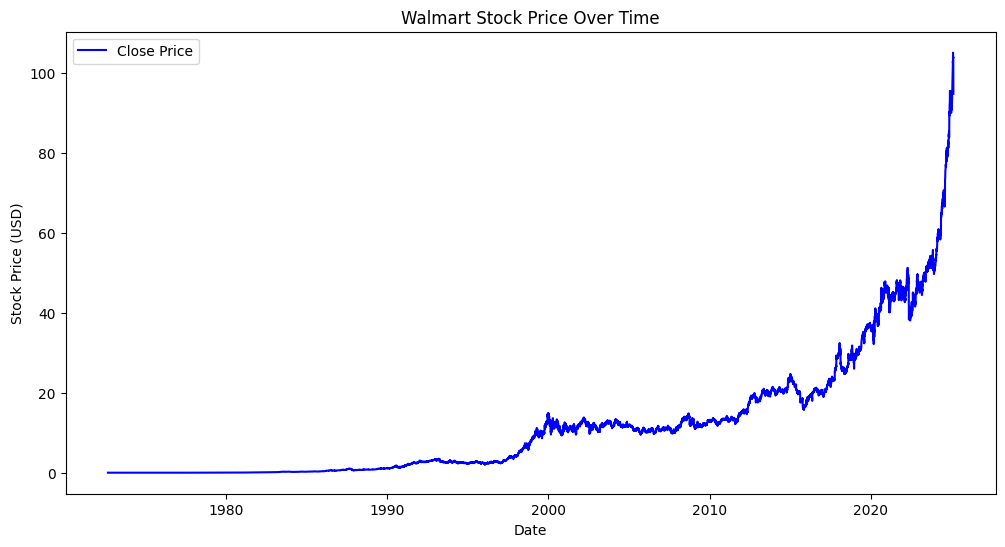

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], color='blue', label="Close Price")
plt.title("Walmart Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

**✅ Observations:**

* **i can see if the stock is in a long-term uptrend or downtrend.**

* **Spikes may indicate major events like earnings reports or economic downturns.**

# **📌 Step 6: Analyzing Volatility Using Moving Averages**

*📈 Calculate 50-Day & 200-Day Moving Averages*

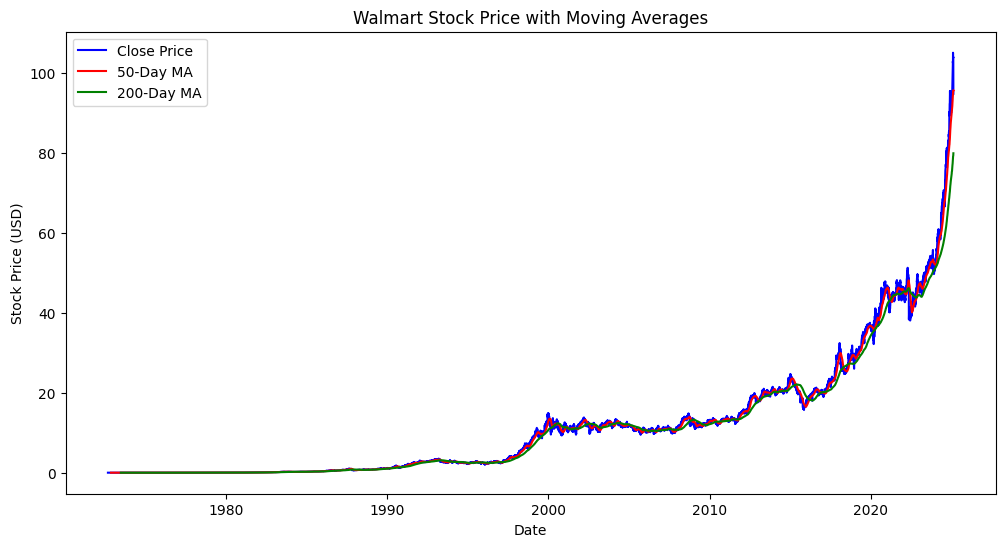

In [8]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], color='blue', label="Close Price")
plt.plot(df.index, df['MA50'], color='red', label="50-Day MA")
plt.plot(df.index, df['MA200'], color='green', label="200-Day MA")
plt.title("Walmart Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

**✅ Why Moving Averages?**

> **The 50-day MA shows short-term trends.**

> **The 200-day MA shows long-term trends.**

# **📌 Step 7: Compute Daily Returns & Volatility**

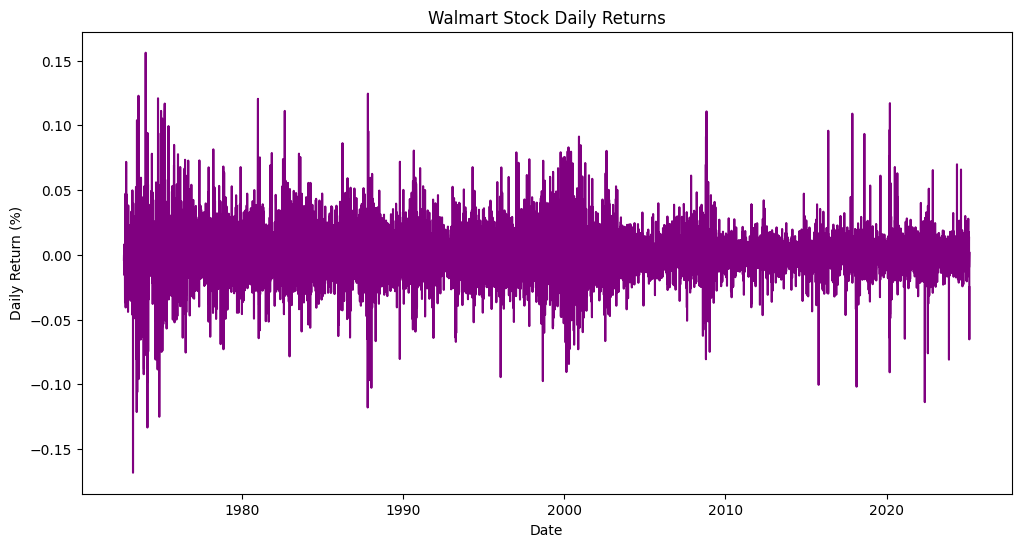

In [9]:
# Compute daily returns
df['Daily Return'] = df['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily Return'], color='purple')
plt.title("Walmart Stock Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.show()

**✅ Why?**

> **Positive returns → Stock is gaining value.**

> **Negative returns → Stock is losing value.**

***🔹 Compute Rolling Volatility***

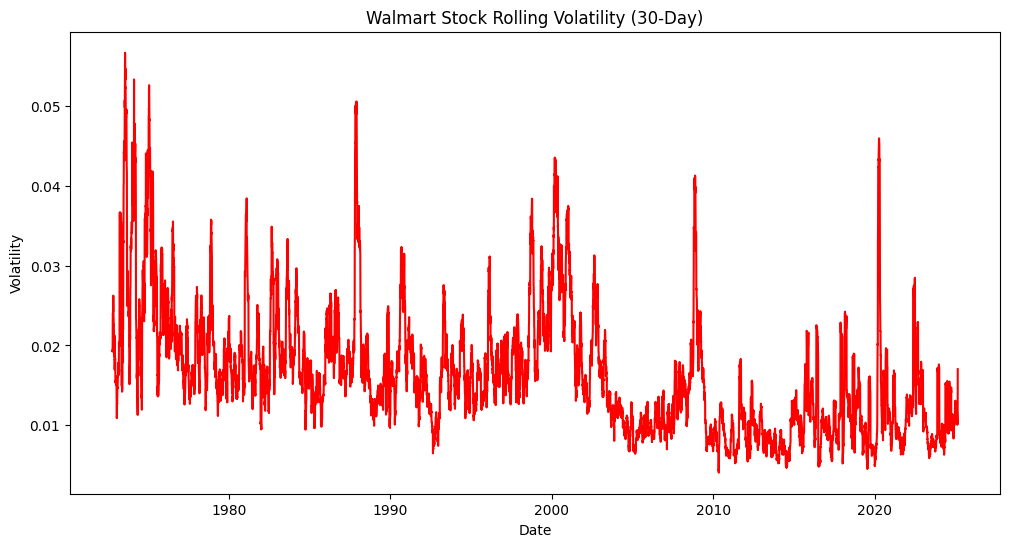

In [10]:
# Compute rolling 30-day standard deviation
df['Volatility'] = df['Daily Return'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volatility'], color='red')
plt.title("Walmart Stock Rolling Volatility (30-Day)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

**✅ High volatility periods may signal market crashes or earnings announcements.**

# **📌 Step 8: Correlation Analysis**

**I'll check relationships between features like Open, Close, High, and Low**

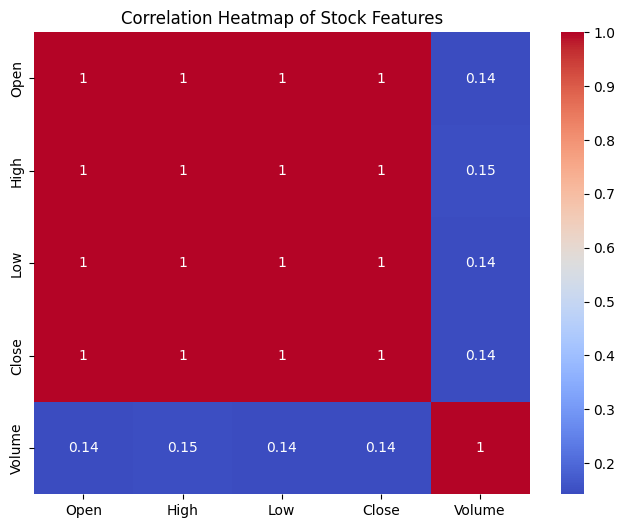

In [11]:
# Compute correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Stock Features")
plt.show()

**✅ Key Observations:**

> **Close price has strong correlation with Open, High, and Low prices.**

> **Volume might have lower correlation with stock prices.**

# **📌 Step 9: Time Series Decomposition**

*I'll decompose the stock price data into trend, seasonality, and residuals*

<Figure size 1000x800 with 0 Axes>

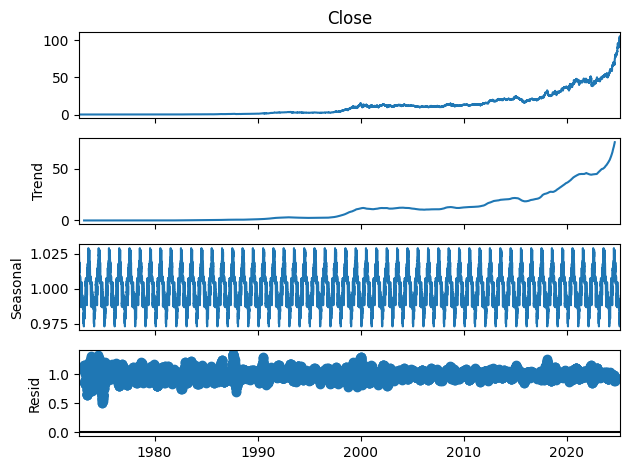

In [12]:
# Decompose time series
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='multiplicative', period=252)

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

**✅ Why?**

> **Trend shows the long-term movement of stock prices.**

> **Seasonality helps identify recurring patterns.**

> **Residuals capture random fluctuations.**

# **🎯 Key Takeaways:**

> Walmart’s stock shows long-term growth with periods of volatility.

> Moving averages smooth fluctuations and reveal trend reversals.

> Daily returns indicate stock risk & performance over time.

> The correlation matrix shows strong relationships between Open, Close, High, and Low prices.

> Time series decomposition helps analyze seasonality and market cycles.

# **📌 Step 10:ARIMA (AutoRegressive Integrated Moving Average)**

ADF Statistic: 7.211611647882241
p-value: 1.0
The series is NOT stationary, differencing is needed.
ADF Statistic: -16.961398814747888
p-value: 9.302604686642665e-30
The series is stationary.
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                13233
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1219.769
Date:                Thu, 06 Mar 2025   AIC                           2445.538
Time:                        02:55:28   BIC                           2468.009
Sample:                             0   HQIC                          2453.040
                              - 13233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1

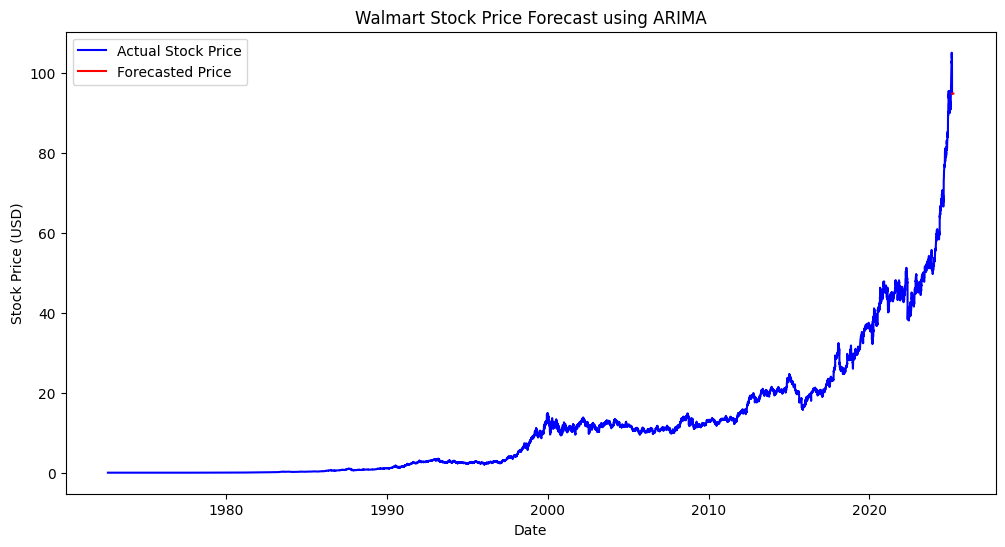

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = "/kaggle/input/walmart-stocks-data-2025/walmart_stock_prices.csv"
df = pd.read_csv(file_path)

# Convert 'Date' to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select 'Close' price for ARIMA model
stock_data = df['Close']

# Step 1: Check stationarity using Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary, differencing is needed.")

adf_test(stock_data)

# Step 2: Apply Differencing if necessary
stock_data_diff = stock_data.diff().dropna()
adf_test(stock_data_diff)

# Step 3: Fit ARIMA Model (p, d, q)
model = ARIMA(stock_data, order=(1,1,1))  # ARIMA(1,1,1) as a simple choice
model_fit = model.fit()
print(model_fit.summary())

# Step 4: Forecast Future Prices
forecast = model_fit.forecast(steps=30)  # Predict next 30 days

# Step 5: Plot Actual vs Predicted Values
plt.figure(figsize=(12,6))
plt.plot(stock_data, label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=stock_data.index[-1], periods=31, freq='D')[1:], forecast, label='Forecasted Price', color='red')
plt.title("Walmart Stock Price Forecast using ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# **📌 Step 11: Data Preparation for Machine Learning**

In [14]:
# Selecting relevant columns
df_ml = df[['Close']].copy()

In [15]:
# Splitting data
train_size = int(len(df_ml) * 0.8)
train, test = df_ml[:train_size], df_ml[train_size:]

print(f"Training Data: {len(train)} records")
print(f"Testing Data: {len(test)} records")

Training Data: 10586 records
Testing Data: 2647 records


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# **📌 Step 12: LSTM Model for Stock Price Prediction**

**LSTM requires sequential data. I'll use a lookback window of 60 days.**

In [17]:
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

**Building the LSTM Model**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 0.0118 - val_loss: 0.2421
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 0.0014 - val_loss: 0.2287
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 0.0011 - val_loss: 0.2711
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 9.6554e-04 - val_loss: 0.2400
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 9.2981e-04 - val_loss: 0.1813
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 8.2473e-04 - val_loss: 0.2247
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 7.4772e-04 - val_loss: 0.1978
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 7.4378e-04 - val_loss: 0.1176
Epoch 9/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 6.9217e-04 - val_loss: 0.1588
Epoch 10/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 7.4792e-04 - val_loss: 0.1132
Epoch 11/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 6.7636e-04 - val_loss: 0.115

# **📌 Step 13: Predicting with LSTM**

In [19]:
# Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Reverse scaling
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


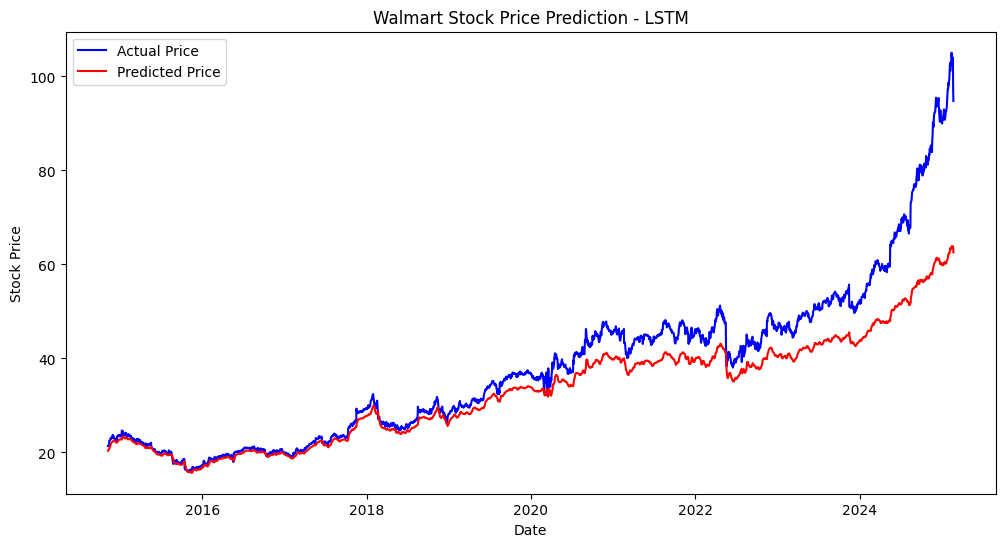

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(test_pred):], y_test_actual, color='blue', label="Actual Price")
plt.plot(df.index[-len(test_pred):], test_pred, color='red', label="Predicted Price")
plt.title("Walmart Stock Price Prediction - LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

**✅ LSTM captures trends but might struggle with sharp fluctuations.**

# **📌 Step 14: Regression Model for Stock Prediction**

In [21]:
df_ml['Target'] = df_ml['Close'].shift(-1)  # Predicting next day's price

# Drop NaN values
df_ml.dropna(inplace=True)

# Feature & target split
X = df_ml[['Close']]
y = df_ml['Target']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression MAE: {mae}")

Linear Regression MAE: 0.32676070018814424


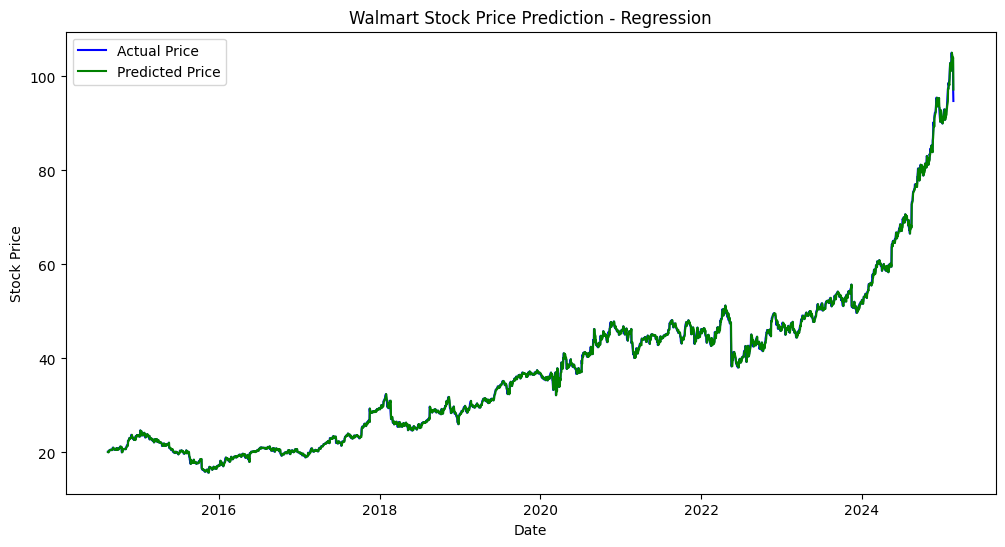

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, color='blue', label="Actual Price")
plt.plot(df.index[-len(y_test):], y_pred, color='green', label="Predicted Price")
plt.title("Walmart Stock Price Prediction - Regression")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

**✅ Linear Regression is a simple model but lacks deep trend capture.**

### 📊 Model Comparison Table

| Model               | Strengths                              | Weaknesses                          |
|---------------------|--------------------------------|--------------------------------|
| **LSTM**           | Captures long-term trends & patterns  | Needs large data & complex tuning |
| **Linear Regression** | Simple & interpretable              | Ignores sequential dependencies  |


> * ✅ LSTM performs better but takes longer to train.

> * ✅ Regression is fast but less accurate. 

### **📜 Full Notebook Description (Summary Steps)**  

🔍 **1. Data Loading & Preprocessing**  
- Load Walmart stock price dataset (`walmart_stock_prices.csv`).  
- Handle missing values, check data types, and format the date column.  

📊 **2. Exploratory Data Analysis (EDA)**  
- Compute statistical measures (mean, median, standard deviation).  
- Visualize stock price trends using line plots, box plots, and histograms.  
- Identify stock volatility using moving averages and correlation heatmaps.  

📈 **3. Time Series Analysis & Feature Engineering**  
- Analyze stock price seasonality and trends over time.  
- Calculate daily, weekly, and monthly stock returns.  
- Apply rolling window functions for moving averages and volatility analysis.  

📉 **4. Predictive Modeling**  
✅ **ARIMA (AutoRegressive Integrated Moving Average)**  
   - Perform stationarity tests (ADF test).  
   - Determine ARIMA parameters (p, d, q) using ACF & PACF plots.  
   - Train ARIMA model and make stock price forecasts.  

✅ **LSTM (Long Short-Term Memory - Deep Learning)**  
   - Normalize stock prices and reshape data for sequential learning.  
   - Build an LSTM model in TensorFlow/Keras.  
   - Train the model and predict future stock prices.  

✅ **Linear Regression & Multiple Regression**  
   - Select relevant stock price features for regression.  
   - Train a linear model and evaluate its performance.  

📊 **5. Model Comparison & Performance Evaluation**  
- Compare ARIMA, LSTM, and Linear Regression predictions.  
- Visualize actual vs. predicted stock prices.  
- Discuss model strengths, weaknesses, and best use cases.  

📌 **6. Insights & Conclusion**  
- Summarize key findings on Walmart’s stock price trends.  
- Discuss stock volatility, patterns, and investment strategies.  
- Highlight the best predictive model for future forecasting. 🚀📈